## Part 3 - Supervised Learning: Generalisation & Overfitting; Decision trees.

Importing the required libraries and checking for the python version.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [3]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [4]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) Using Decision Trees (on the training dataset only)

In [5]:
from sklearn.tree import DecisionTreeClassifier

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

dt_train = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt_train.fit(xtrain_images, y_train) 

predictions = dt_train.predict(x_train)

<function matplotlib.pyplot.show(close=None, block=None)>

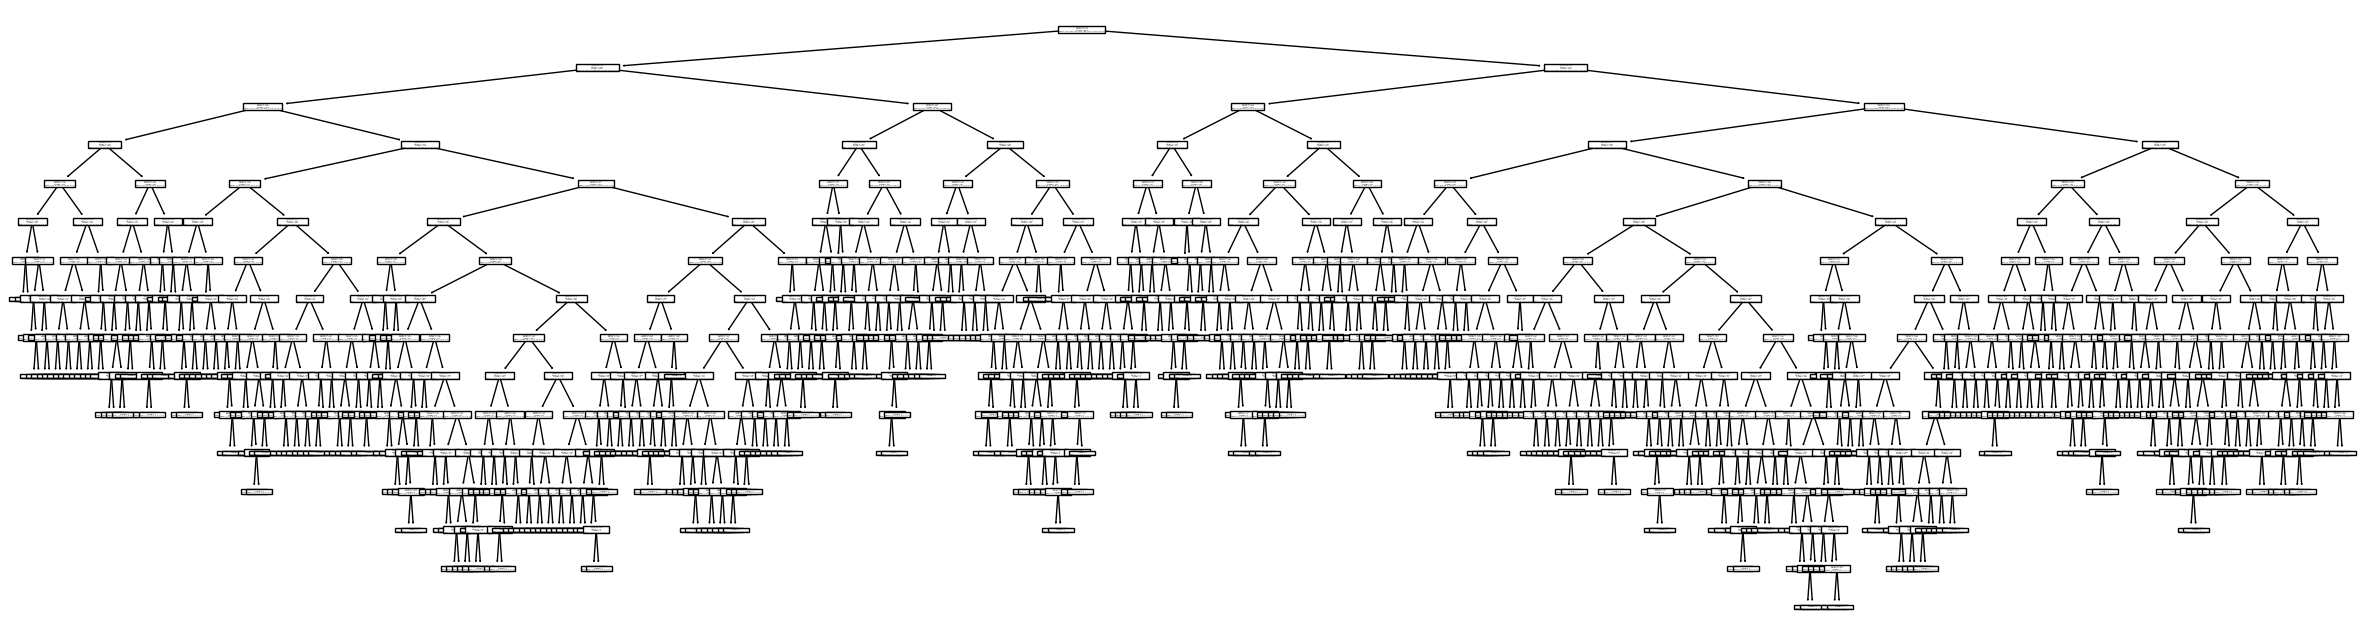

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 8))
plot_tree(dt_train)
plt.show

#### 1.1) Evaluation on training dataset

In [8]:
from sklearn.metrics import classification_report

report_train = classification_report(y_train, predictions)

print(report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690



In [7]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, predictions)
print('Accuracy on training dataset = ', accuracy_train)

Accuracy on training dataset =  1.0


In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train, predictions)
confusion_matrix_train

array([[ 210,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2220,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2250,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1410,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1980,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  210,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  360,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  240,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  540,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  270]])

<Axes: >

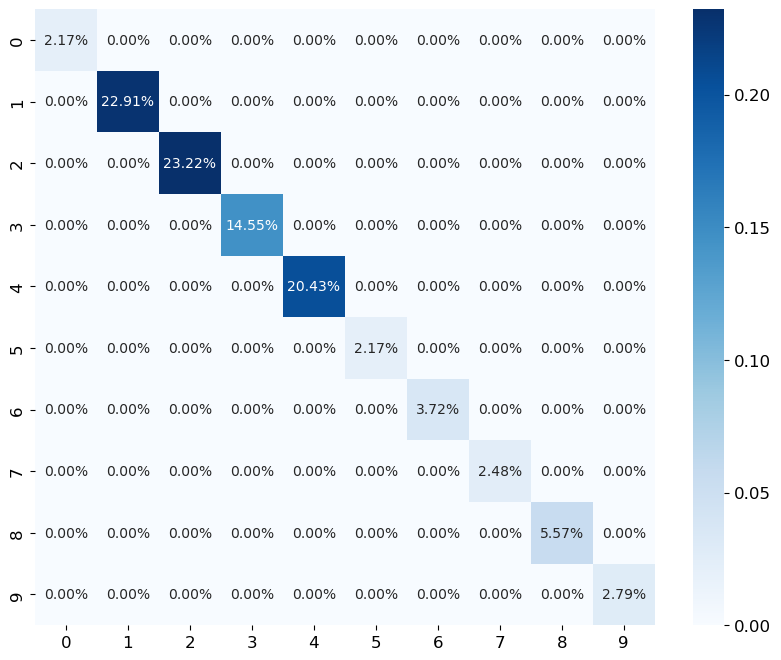

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score

def calculate_metrics_and_mean_train(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)

    result_df = pd.concat([result_df, auc_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [13]:
calculate_metrics_and_mean_train(x_train, y_train, predictions, dt_train)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


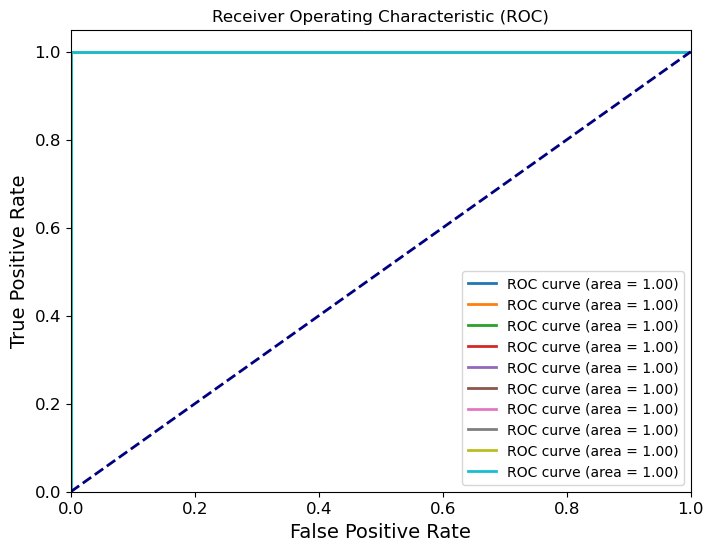

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_dt_train = dt_train.predict_proba(x_train)
roc_auc_scores_dt_train = []

plt.figure(figsize=(8, 6))
unique_labels_dt_train = np.unique(y_train)

for i in range(len(unique_labels_dt_train)):
    fpr_dt_train, tpr_dt_train, _ = roc_curve((y_train == unique_labels_dt_train[i]).astype(int), probabilities_dt_train[:, i])
    roc_auc_dt_train = auc(fpr_dt_train, tpr_dt_train)
    roc_auc_scores_dt_train.append(roc_auc_dt_train)
    plt.plot(fpr_dt_train, tpr_dt_train, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_dt_train))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 1.2) Cross Validation on train dataset

In [15]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [16]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.6130031  0.68833849 0.72033024 0.71826625 0.68833849 0.78018576
 0.64189886 0.77296182 0.71517028 0.74922601]
Mean: 0.7087719298245615
Standard deviation: 0.05059665136882167


In [17]:
scores1 = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=5)
display_scores(scores1)

Scores: [0.59855521 0.69762642 0.71878225 0.68421053 0.73477812]
Mean: 0.6867905056759545
Standard deviation: 0.04740426863923986


In [18]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
dt_train_nmse_scores = np.sqrt(-scores)
display_scores(dt_train_nmse_scores)

Scores: [1.93495893 1.5711538  1.41567227 1.59268192 1.78284452 1.48435251
 1.76918935 1.42112907 1.4899041  1.41348365]
Mean: 1.587537011409106
Standard deviation: 0.17315956612979827


### 2) Using Decision Trees (on the train and test datasets)

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc_curve(dt, x_test, y_test, resolution=199):
    probabilities_dt = dt.predict_proba(x_test)
    roc_auc_scores_dt = []

    plt.figure(figsize=(8, 6))
    unique_labels_dt = np.unique(y_train)

    for i in range(len(unique_labels_dt)):
        fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels_dt[i]).astype(int), probabilities_dt[:, i])
        roc_auc_dt = auc(fpr_dt, tpr_dt)
        roc_auc_scores_dt.append(roc_auc_dt)

        # Increase the resolution for smoother curves
        fpr_interp = np.interp(np.linspace(0, 1, resolution), fpr_dt, tpr_dt)
        plt.plot(np.linspace(0, 1, resolution), fpr_interp, lw=2, label=f'ROC curve (class {unique_labels_dt[i]}, area = {roc_auc_dt:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multiclass Decision Tree')
    plt.legend(loc='lower right')
    plt.show()

In [21]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt.fit(x_train, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42)

In [22]:
x_test.shape

(3090, 2304)

In [24]:
x_test = np.asarray(x_test)
y_test = np.array(y_test)

In [25]:
y_pred = dt.predict(x_test)

calculate_metrics_and_mean(x_test, y_test, y_pred, dt)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.412500,0.550000,0.471429,0.550000,0.015512,0.984488,0.550000,0.796454,0.726861,0.8411,0.016275
1,0.720050,0.793056,0.754792,0.793056,0.093671,0.906329,0.793056,0.796454,NaN,NaN,NaN
2,0.768309,0.769333,0.768821,0.769333,0.074359,0.925641,0.769333,0.796454,NaN,NaN,NaN
3,0.737705,0.700000,0.718358,0.700000,0.042424,0.957576,0.700000,0.796454,NaN,NaN,NaN
4,0.825083,0.757576,0.789889,0.757576,0.043621,0.956379,0.757576,0.796454,NaN,NaN,NaN
5,0.814815,0.733333,0.771930,0.733333,0.003300,0.996700,0.733333,0.796454,NaN,NaN,NaN
6,0.505376,0.522222,0.513661,0.522222,0.015333,0.984667,0.522222,0.796454,NaN,NaN,NaN
7,0.531250,0.283333,0.369565,0.283333,0.004950,0.995050,0.283333,0.796454,NaN,NaN,NaN
8,0.631579,0.640000,0.635762,0.640000,0.019048,0.980952,0.640000,0.796454,NaN,NaN,NaN
9,0.450980,0.511111,0.479167,0.511111,0.018667,0.981333,0.511111,0.796454,NaN,NaN,NaN


### 3) Experimenting with Decision Tree parameters

<br/>Reference : https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

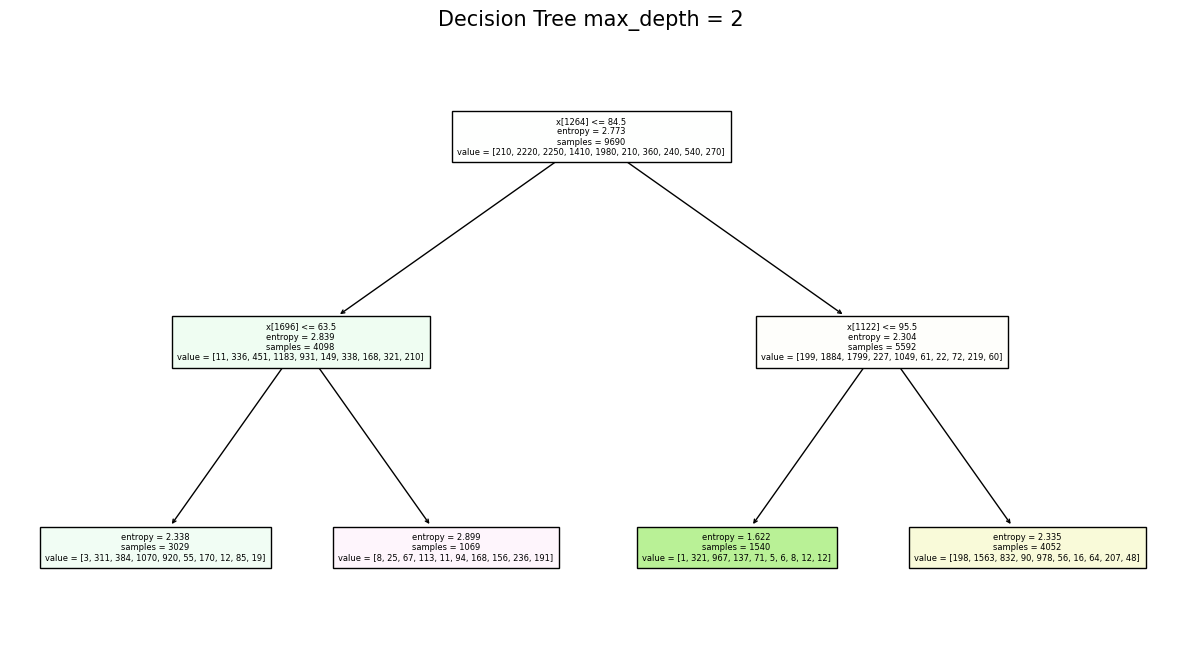

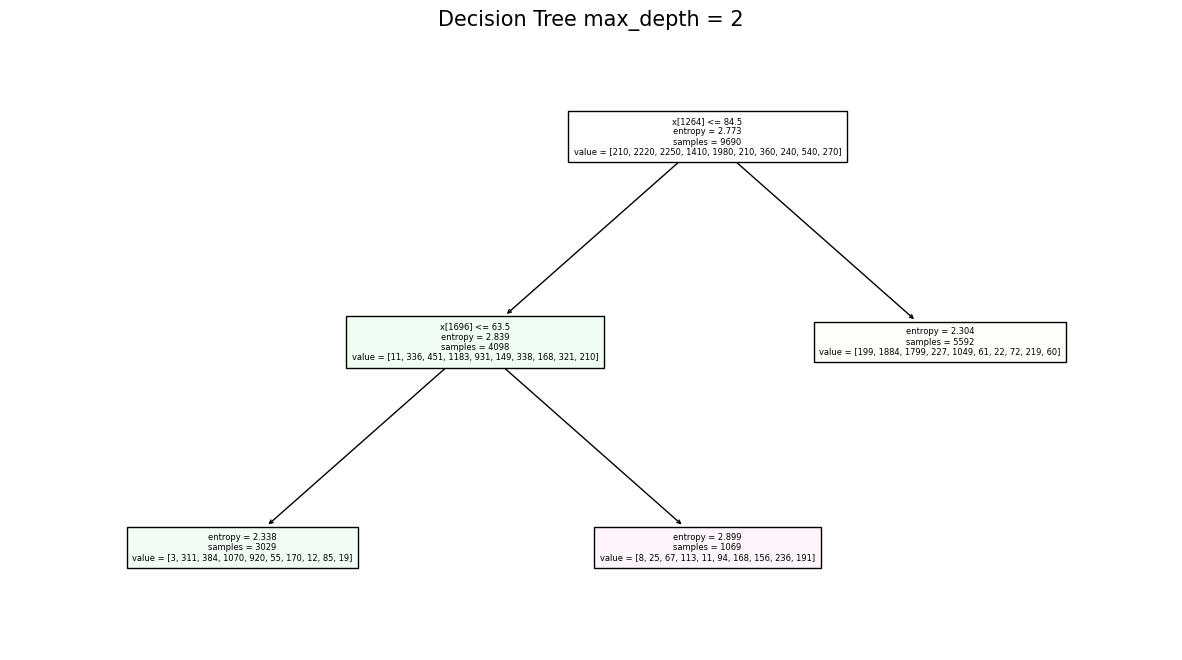

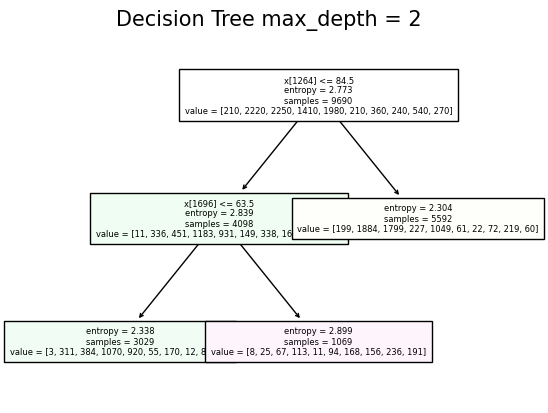

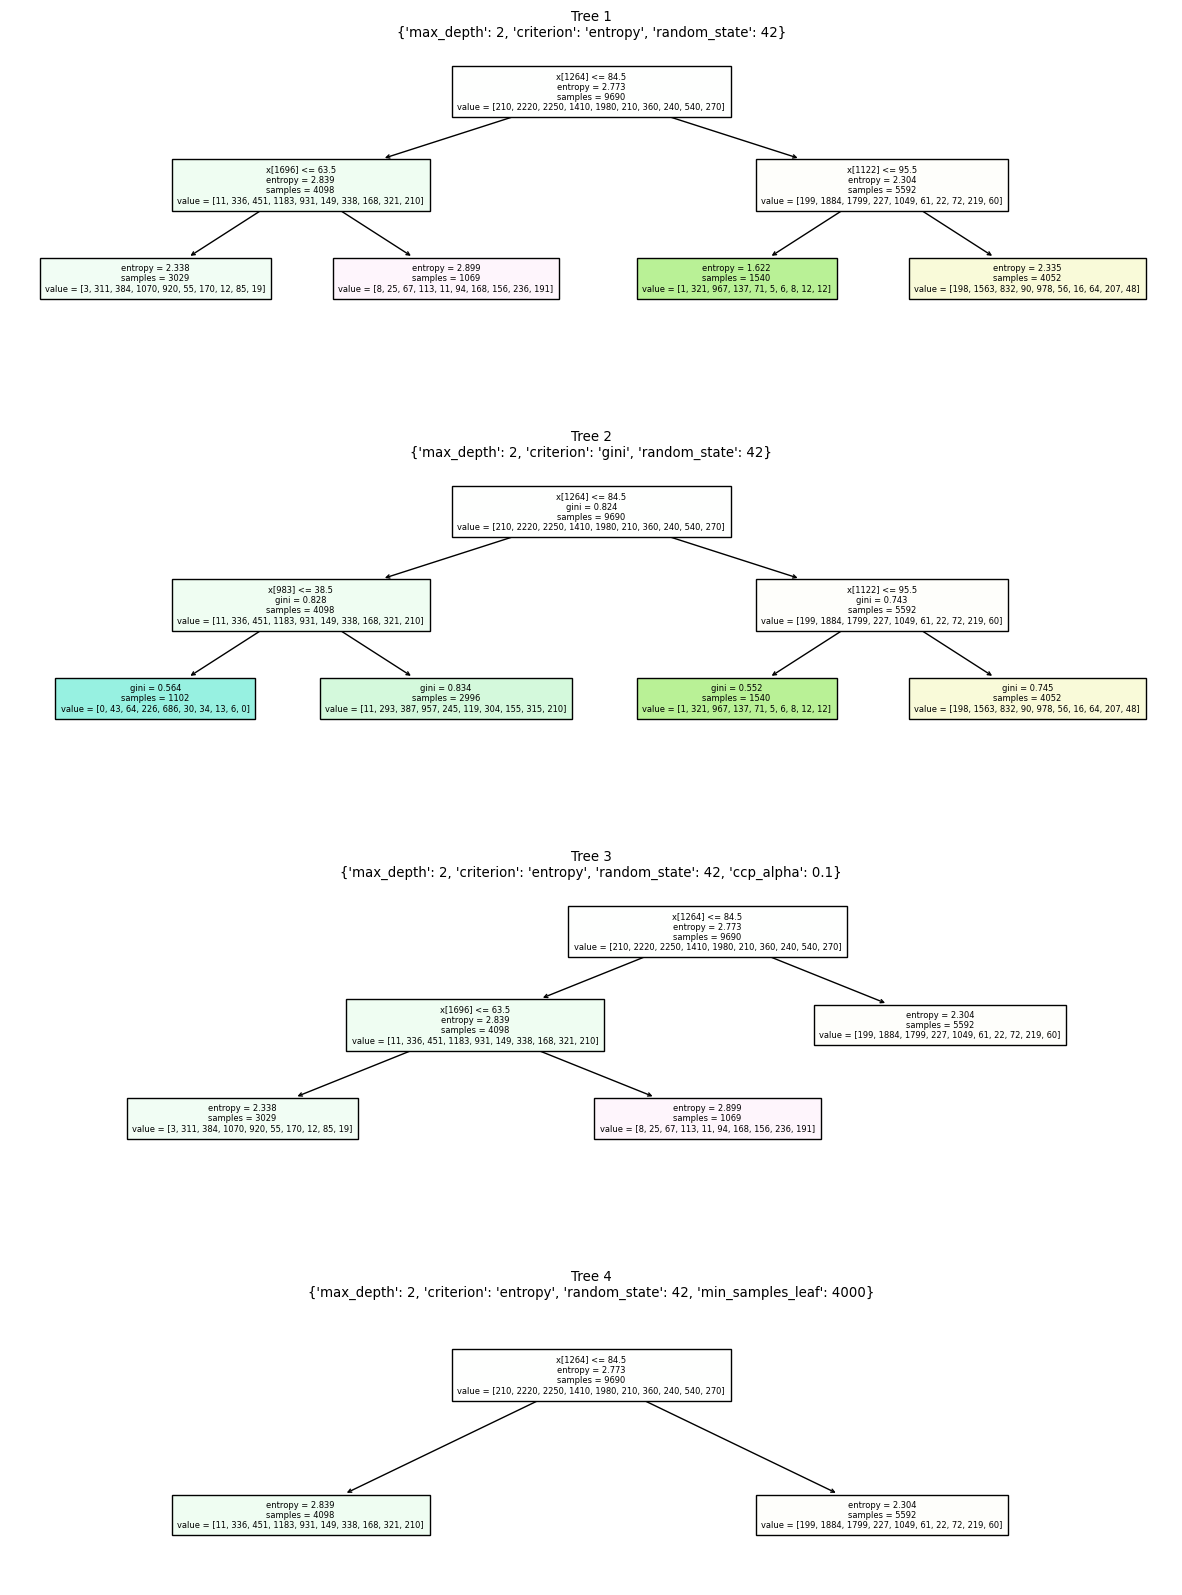

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

dt_train = DecisionTreeClassifier(max_depth=2,criterion='entropy',random_state=42)
dt_train.fit(xtrain_images, y_train) 
dt_train.predict(x_train[0:5])
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 8


tree.plot_tree(dt_train, filled=True, fontsize=6)
plt.title("Decision Tree max_depth = 2", fontsize= 15)
plt.show()



dt_train = DecisionTreeClassifier(max_depth=2,criterion='entropy',random_state=42, ccp_alpha= 0.1)
dt_train.fit(xtrain_images, y_train) 
dt_train.predict(x_train[0:5])
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 8


tree.plot_tree(dt_train, filled=True, fontsize=6)
plt.title("Decision Tree max_depth = 2", fontsize= 15)
plt.show()


tree.plot_tree(dt_train, filled=True, fontsize=6)
plt.title("Decision Tree max_depth = 2", fontsize= 15)
plt.show()


x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

hyperparameters = [
    {'max_depth': 2, 'criterion': 'entropy' , 'random_state':42},
    {'max_depth': 2, 'criterion': 'gini', 'random_state':42 },
    {'max_depth': 2, 'criterion': 'entropy', 'random_state':42,'ccp_alpha':0.1 },
    {'max_depth': 2, 'criterion': 'entropy', 'random_state':42, 'min_samples_leaf': 4000 },

]

fig, axes = plt.subplots(len(hyperparameters), 1, figsize=(15, 20))

for i, params in enumerate(hyperparameters):
    dt_train = DecisionTreeClassifier(**params)
    dt_train.fit(xtrain_images, y_train)
    plt.rcParams['font.size'] = 8
    tree.plot_tree(dt_train, filled=True, fontsize=6, ax=axes[i])
    axes[i].set_title(f"Tree {i + 1}\n{params}")

    
plt.subplots_adjust(hspace=0.5)
plt.show()

#### 3.1) Changing Depth of the tree

##### Parameter Tuning in the training dataset 


In [27]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def mean_cross_val_scores(model, x_train, y_train):
    scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)
    return scores.mean()

In [28]:
tree_depth = np.linspace(1, 20,20)
accuracy_scores = []
mean_cv_scores = []

In [29]:
print([int(x) for x in tree_depth])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [30]:
for i in tree_depth:
    clf = DecisionTreeClassifier(max_depth= int(i))
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy_scores.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf,x_train,y_train)
    mean_cv_scores.append(mean)

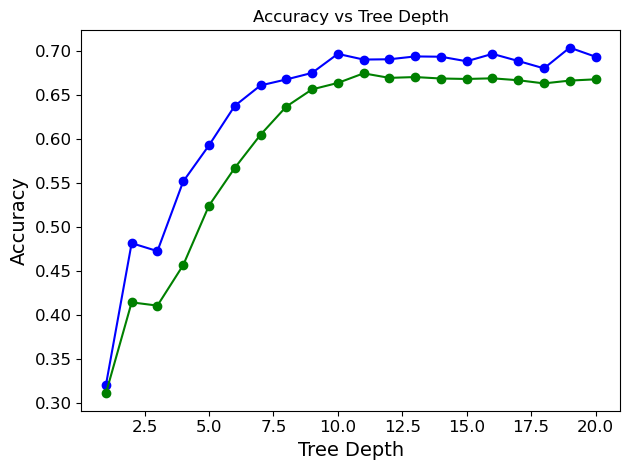

In [31]:
plt.plot(tree_depth, accuracy_scores, "bo-")
plt.plot(tree_depth, mean_cv_scores, "go-")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth")
plt.tight_layout()
plt.show()

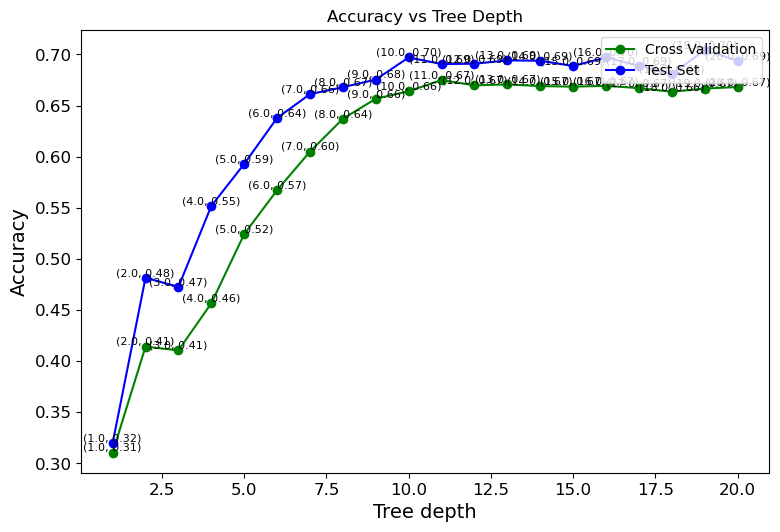

In [81]:
# Subplot for Accuracy vs Tree Depth
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plot_hyperparameters("Accuracy vs Tree Depth","Tree depth","Accuracy",tree_depth, mean_cv_scores, accuracy_scores)

In [32]:
accuracy_scores

[0.31974110032362457,
 0.4815533980582524,
 0.47249190938511326,
 0.551779935275081,
 0.5928802588996763,
 0.6378640776699029,
 0.6611650485436893,
 0.6679611650485436,
 0.6754045307443366,
 0.6970873786407767,
 0.6906148867313916,
 0.6909385113268608,
 0.6941747572815534,
 0.6938511326860841,
 0.6886731391585761,
 0.6970873786407767,
 0.6889967637540453,
 0.6805825242718446,
 0.7042071197411003,
 0.6938511326860841]

In [33]:
mean_cv_scores
# Decision Tree of size 16 gives the best cross validation score - 0.6692466460268318

[0.3104231166150671,
 0.41413828689370485,
 0.41042311661506703,
 0.45655314757481946,
 0.5242518059855522,
 0.5671826625386996,
 0.604953560371517,
 0.6370485036119711,
 0.656656346749226,
 0.663983488132095,
 0.6749226006191951,
 0.6697626418988648,
 0.6706914344685242,
 0.6690402476780186,
 0.6685242518059855,
 0.6692466460268318,
 0.6670794633642931,
 0.663467492260062,
 0.6666666666666667,
 0.6681114551083592]

#### 3.2) Confidence threshold for pruning 

In [35]:
ccp_alpha_list = [0.0, 0.01 ,0.02, 0.05 ,0.07, 0.1]
accuracy_score_alpha = []
cv_alpha = []

for alpha in ccp_alpha_list: 
        clf = DecisionTreeClassifier( max_depth=17, ccp_alpha=alpha )
        clf = clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        accuracy_score_alpha.append(metrics.accuracy_score(y_test,y_pred))
        mean = mean_cross_val_scores(clf, x_train, y_train)
        cv_alpha.append(mean)

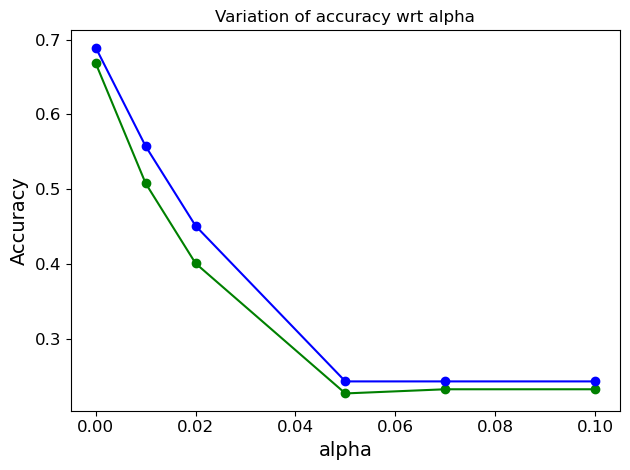

In [36]:
plt.plot(ccp_alpha_list, cv_alpha , "go-")
plt.plot(ccp_alpha_list, accuracy_score_alpha, "bo-")

plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Variation of accuracy wrt alpha")
plt.tight_layout()
plt.show()

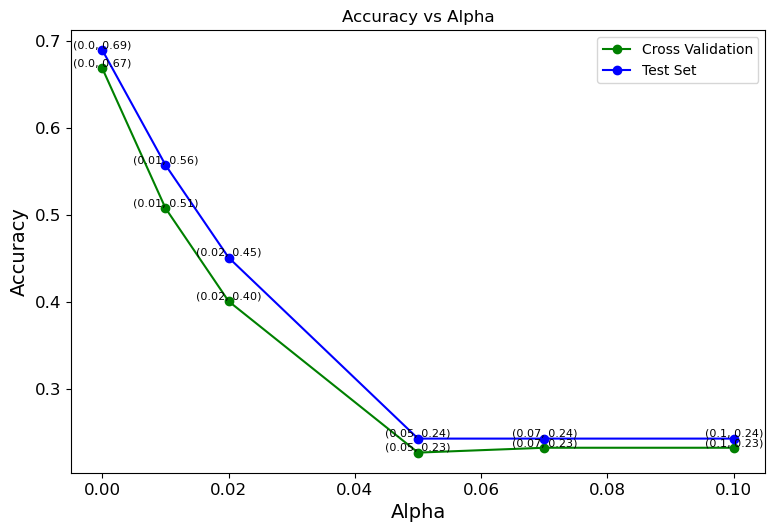

In [82]:
# Subplot for Accuracy vs Alpha
plt.figure(figsize=(15, 10))
plt.subplot(2,2,2)
plot_hyperparameters("Accuracy vs Alpha","Alpha","Accuracy",ccp_alpha_list, cv_alpha, accuracy_score_alpha)

#### 3.3) Splitting Criteria 

In [37]:
splitting_nodes = [2,5,8,10,20]
accuracy_scores_nodes = []
cv_nodes = []

for node in splitting_nodes:
    clf = DecisionTreeClassifier(max_depth=17, min_samples_split=node)
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy_scores_nodes.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf,x_train,y_train)
    cv_nodes.append(mean)

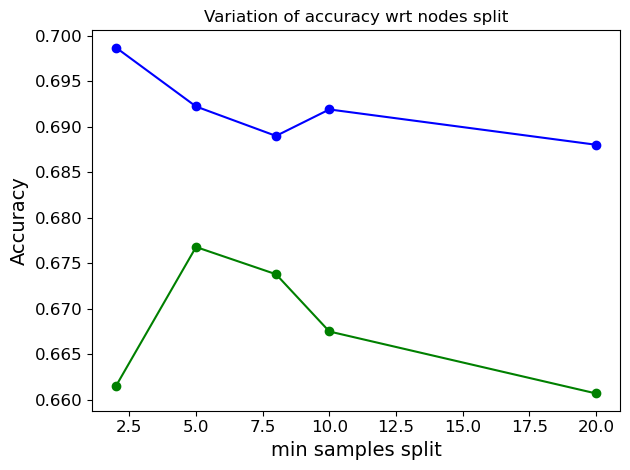

In [38]:
plt.plot(splitting_nodes, cv_nodes , "go-")
plt.plot(splitting_nodes, accuracy_scores_nodes, "bo-")

plt.xlabel("min samples split")
plt.ylabel("Accuracy")
plt.title("Variation of accuracy wrt nodes split")
plt.tight_layout()
plt.show()

#### 3.4) Mininum number of instances permissible per leaf

In [39]:
leaf = np.linspace(1, 20, 10)
cv_leaf = []
accuracy_score_leafs = []

for i in leaf:
    clf = DecisionTreeClassifier( max_depth=17, min_samples_leaf = int(i))
    clf = clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    accuracy_score_leafs.append(metrics.accuracy_score(y_test,y_pred))
    mean = mean_cross_val_scores(clf, x_train, y_train)

    
    cv_leaf.append(mean)

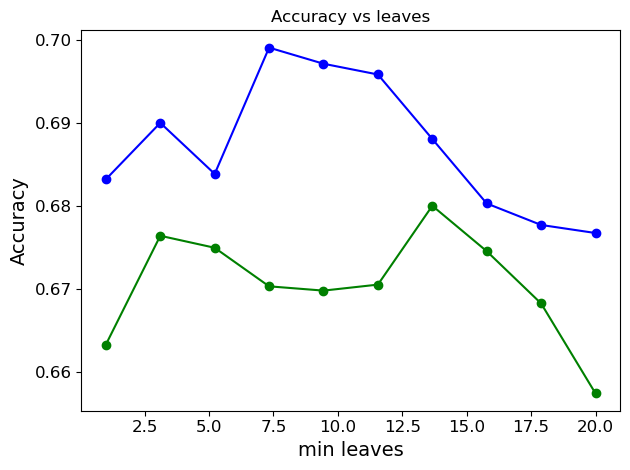

In [40]:
plt.plot(leaf, cv_leaf , "go-")
plt.plot(leaf, accuracy_score_leafs, "bo-")

plt.xlabel("min leaves")
plt.ylabel("Accuracy")
plt.title("Accuracy vs leaves")
plt.tight_layout()
plt.show()

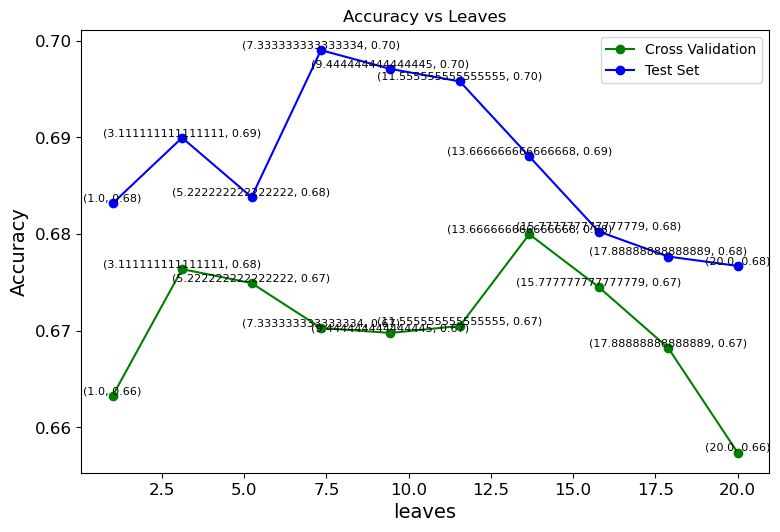

In [85]:
# Subplot for Accuracy vs Leaves
plt.figure(figsize=(15, 10))
plt.subplot(2,2,4)
plot_hyperparameters("Accuracy vs Leaves","leaves","Accuracy",leaf, cv_leaf, accuracy_score_leafs)

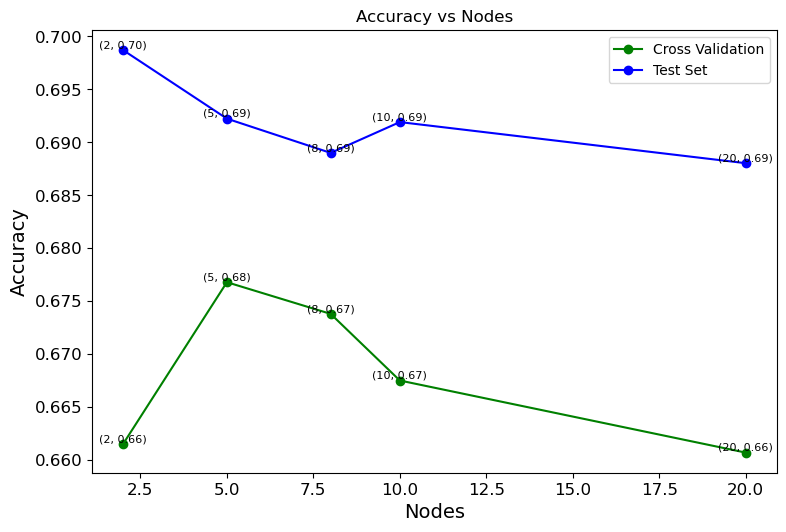

In [84]:
# Subplot for Accuracy vs Nodes
plt.figure(figsize=(15, 10))
plt.subplot(2,2,3)
plot_hyperparameters("Accuracy vs Nodes", "Nodes", "Accuracy", splitting_nodes, cv_nodes, accuracy_scores_nodes)

In [41]:
print([int(x) for x in leaf])

[1, 3, 5, 7, 9, 11, 13, 15, 17, 20]


In [70]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [None,1,5,10,16,17], 
    'criterion' : ['gini','entropy'],
    'min_samples_split': [2,5,8],
    'min_samples_leaf' : [5,7,9],
    'ccp_alpha' : [0.0,0.01,0.02,0.05]
}

gridSearch = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=10,
    scoring='accuracy',
    n_jobs=-1 )

gridSearch.fit(x_train, y_train)

best_parameters = gridSearch.best_params_

best_cross_val_score = gridSearch.best_score_

print(best_parameters)
print(best_cross_val_score)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.7157894736842104


In [10]:
optimised_dt = DecisionTreeClassifier(max_depth=None,min_samples_leaf=5,min_samples_split=2,ccp_alpha=0.0,criterion='entropy')
optimised_dt.fit(x_train,y_train)
y_pred_train = optimised_dt.predict(x_train)
y_pred_test = optimised_dt.predict(x_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9549019607843138
Test Accuracy: 0.7245954692556634


### 4) Making new training and test datasets by moving 30% train dataset to test dataset

In [107]:
# Here, we split the training dataset and combine the 30% of test split with the original test dataset.
from sklearn.model_selection import train_test_split

seed_value = 24

x_train_split_30, x_test_split_30, y_train_split_30, y_test_split_30 = train_test_split(xtrain_images, y_train, test_size=0.3, random_state=seed_value)

x_test_30 = np.vstack((x_test, x_test_split_30))

if len(y_test.shape) != len(y_test_split_30.shape):
    if len(y_test.shape) > len(y_test_split_30.shape):
        y_test_split_30 = y_test_split_30.reshape(-1, 1)
    else:
        y_test = y_test.reshape(-1, 1)

y_test_30 = np.concatenate((y_test, y_test_split_30))

#### 4.1) Using the original Decision Tree parameters

In [108]:
dt_train_30 = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt_train_30.fit(x_train_split_30, y_train_split_30) 

train_predictions_30 = dt_train_30.predict(x_train_split_30)
test_predictions_30 = dt_train_30.predict(x_test_30)

train_accuracy_30 = accuracy_score(y_train_split_30, train_predictions_30)
print('Accuracy on 70% training dataset with Original Decision Tree Parameters = ', train_accuracy_30)

test_accuracy_30 = accuracy_score(y_test_30, test_predictions_30)
print('Accuracy on 30% training + testing dataset with Original Decision Tree Parameters = ', test_accuracy_30)

Accuracy on 70% training dataset with Original Decision Tree Parameters =  1.0
Accuracy on 30% training + testing dataset with Original Decision Tree Parameters =  0.7623811905952976


In [109]:
class_rep_30 = classification_report(y_test_30, test_predictions_30, zero_division=1)
print('Classification Report on 30% training + testing dataset with Original Decision Tree Parameters = ')
print(class_rep_30)

Classification Report on 30% training + testing dataset with Original Decision Tree Parameters = 
              precision    recall  f1-score   support

           0       0.48      0.57      0.52       123
           1       0.79      0.78      0.78      1387
           2       0.78      0.80      0.79      1431
           3       0.78      0.79      0.79       878
           4       0.81      0.82      0.82      1263
           5       0.69      0.47      0.56       110
           6       0.62      0.63      0.62       203
           7       0.54      0.56      0.55       133
           8       0.75      0.65      0.70       314
           9       0.55      0.53      0.54       155

    accuracy                           0.76      5997
   macro avg       0.68      0.66      0.67      5997
weighted avg       0.76      0.76      0.76      5997



#### 4.2) Using the best Decision Tree parameters after experimenting

In [110]:
dt_train_30_ndt = DecisionTreeClassifier(max_depth=None,min_samples_leaf=5,min_samples_split=2,ccp_alpha=0.0,criterion='entropy')
dt_train_30_ndt.fit(x_train_split_30, y_train_split_30) 

train_predictions_30_ndt = dt_train_30_ndt.predict(x_train_split_30)
test_predictions_30_ndt = dt_train_30_ndt.predict(x_test_30)

train_accuracy_30_ndt = accuracy_score(y_train_split_30, train_predictions_30_ndt)
print('Train Accuracy on 70% training dataset with New Decision Tree Parameters = ', train_accuracy_30_ndt)

test_accuracy_30_ndt = accuracy_score(y_test_30, test_predictions_30_ndt)
print('Test Accuracy on 30% training + testing dataset with New Decision Tree Parameters = ', test_accuracy_30_ndt)

Train Accuracy on 70% training dataset with New Decision Tree Parameters =  0.9504643962848297
Test Accuracy on 30% training + testing dataset with New Decision Tree Parameters =  0.7590461897615475


In [111]:
class_rep_30_ndt = classification_report(y_test_30, test_predictions_30_ndt, zero_division=1)
print('Classification Report on 30% training + testing dataset with New Decision Tree Parameters = ')
print(class_rep_30_ndt)

Classification Report on 30% training + testing dataset with New Decision Tree Parameters = 
              precision    recall  f1-score   support

           0       0.43      0.52      0.47       123
           1       0.76      0.79      0.78      1387
           2       0.79      0.81      0.80      1431
           3       0.79      0.76      0.78       878
           4       0.80      0.80      0.80      1263
           5       0.76      0.56      0.65       110
           6       0.63      0.63      0.63       203
           7       0.59      0.47      0.53       133
           8       0.75      0.72      0.73       314
           9       0.55      0.48      0.51       155

    accuracy                           0.76      5997
   macro avg       0.69      0.65      0.67      5997
weighted avg       0.76      0.76      0.76      5997



### 5) Making new training and test datasets by moving 60% train dataset to test dataset

In [112]:
# Here, we split the training dataset and combine the 60% of test split with the original test dataset.
x_train_split_60, x_test_split_60, y_train_split_60, y_test_split_60 = train_test_split(xtrain_images, y_train, test_size=0.6, random_state=seed_value)

x_test_60 = np.vstack((x_test, x_test_split_60))

if len(y_test.shape) != len(y_test_split_60.shape):
    if len(y_test.shape) > len(y_test_split_60.shape):
        y_test_split_60 = y_test_split_60.reshape(-1, 1)
    else:
        y_test = y_test.reshape(-1, 1)

y_test_60 = np.concatenate((y_test, y_test_split_60))

#### 5.1) Using the original Decision Tree parameters

In [113]:
dt_train_60 = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt_train_60.fit(x_train_split_60, y_train_split_60) 

train_predictions_60 = dt_train_60.predict(x_train_split_60)
test_predictions_60 = dt_train_60.predict(x_test_60)

train_accuracy_60 = accuracy_score(y_train_split_60, train_predictions_60)
print('Accuracy on 40% training dataset with Original Decision Tree Parameters = ', train_accuracy_60)

test_accuracy_60 = accuracy_score(y_test_60, test_predictions_60)
print('Accuracy on 60% training + testing dataset with Original Decision Tree Parameters = ', test_accuracy_60)

Accuracy on 40% training dataset with Original Decision Tree Parameters =  1.0
Accuracy on 60% training + testing dataset with Original Decision Tree Parameters =  0.7451707097933513


In [114]:
class_rep_60 = classification_report(y_test_60, test_predictions_60, zero_division=1)
print('Classification Report on 60% training + testing dataset with Original Decision Tree Parameters = ')
print(class_rep_60)

Classification Report on 60% training + testing dataset with Original Decision Tree Parameters = 
              precision    recall  f1-score   support

           0       0.45      0.54      0.49       175
           1       0.76      0.75      0.76      2057
           2       0.77      0.75      0.76      2120
           3       0.79      0.78      0.79      1303
           4       0.78      0.80      0.79      1859
           5       0.58      0.54      0.56       180
           6       0.63      0.62      0.62       297
           7       0.68      0.59      0.64       194
           8       0.70      0.75      0.73       475
           9       0.55      0.61      0.58       244

    accuracy                           0.75      8904
   macro avg       0.67      0.67      0.67      8904
weighted avg       0.75      0.75      0.75      8904



#### 5.2) Using the best Decision Tree parameters after experimenting

In [115]:
dt_train_60_ndt = DecisionTreeClassifier(max_depth=None,min_samples_leaf=5,min_samples_split=2,ccp_alpha=0.0,criterion='entropy')
dt_train_60_ndt.fit(x_train_split_60, y_train_split_60) 

train_predictions_60_ndt = dt_train_60_ndt.predict(x_train_split_60)
test_predictions_60_ndt = dt_train_60_ndt.predict(x_test_60)

train_accuracy_60_ndt = accuracy_score(y_train_split_60, train_predictions_60_ndt)
print('Accuracy on 40% training dataset with New Decision Tree Parameters = ', train_accuracy_60_ndt)

test_accuracy_60_ndt = accuracy_score(y_test_60, test_predictions_60_ndt)
print('Accuracy on 60% training + testing dataset with New Decision Tree Parameters = ', test_accuracy_60_ndt)

Accuracy on 40% training dataset with New Decision Tree Parameters =  0.936016511867905
Accuracy on 60% training + testing dataset with New Decision Tree Parameters =  0.7404537286612758


In [116]:
class_rep_60_ndt = classification_report(y_test_60, test_predictions_60_ndt, zero_division=1)
print('Classification Report on 60% training + testing dataset with New Decision Tree Parameters = ')
print(class_rep_60_ndt)

Classification Report on 60% training + testing dataset with New Decision Tree Parameters = 
              precision    recall  f1-score   support

           0       0.45      0.69      0.55       175
           1       0.73      0.76      0.75      2057
           2       0.75      0.76      0.75      2120
           3       0.82      0.75      0.78      1303
           4       0.79      0.79      0.79      1859
           5       0.58      0.58      0.58       180
           6       0.64      0.57      0.61       297
           7       0.69      0.51      0.59       194
           8       0.75      0.71      0.73       475
           9       0.57      0.60      0.58       244

    accuracy                           0.74      8904
   macro avg       0.68      0.67      0.67      8904
weighted avg       0.74      0.74      0.74      8904



### 6) Analyzing Results from the point of view of the problem of classifier over-fitting

The decision classifier exhibits the signs of overfitting. The classifier achieves a training accuracy of 100%. However, the cross validation score and the testing accuracy drops down to 70% and 72.68% respectively. This indicates that the classifier does not do well with unseen data due to the fact that it has memorized the training data. The same is observed in the new training and testing datasets with 30% and 60% of the training samples moved to the testing set to create 2 new training and testing datasets. The classifier achieves a training accuracy of 100% but the testing accuracy drops down to 76.23% and 74.51% respectively for the 2 new datasets using the original decision classifier parameters.

The decision classifier with the optimal parameters, trained and tested on the original and new datasets, also show signs of potential overfitting. The original datasets achieve a training accuracy of 95.49% and testing accuracy of 72.45%. The dataset with 30% of its training instances moved to the testing set, achieves a training accuracy of 95.04% and a testing accuracy of 75.90%. The dataset with 60% of its training instances moved to the testing set, achieves a training accuracy of 93.6% and a testing accuracy of 74.04%. 

### 7) Random Forest Classifier

#### 7.1) Using Training Dataset only

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
# random_state: controls randomness of the sample
# n_jobs: number of processors the engine is allowed to use. -1 no limit
# max_depth: depth
# n_estimators: number of trees the forest builds
# oob_score: Out-Of-The-Bag. random forest cross validation 

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

In [ ]:
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
classifier_rf.oob_score_

0.7186790505675955

In [ ]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(classifier_rf, x_train, y_train, cv=10, scoring='accuracy')

print(f'Cross Validation Scores: {cv}')
print(f'Mean Accuracy: {cv.mean()}')
print(f'Standard Deviation: {cv.std()}')

Cross Validation Scores: [0.46439628 0.48503612 0.57688338 0.68317853 0.66150671 0.65944272
 0.3880289  0.6006192  0.70381837 0.64705882]
Mean Accuracy: 0.5869969040247678
Standard Deviation: 0.10129596958817277


In [ ]:
y_predict = classifier_rf.predict(x_train)

In [ ]:
conf_matrix = confusion_matrix(y_train, y_predict)

accuracy = accuracy_score(y_train, y_predict)
report = classification_report(y_train, y_predict, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n {report}')

Accuracy: 0.7542827657378741
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       210
           1       0.70      0.85      0.77      2220
           2       0.72      0.81      0.77      2250
           3       0.69      0.80      0.74      1410
           4       0.87      0.83      0.85      1980
           5       1.00      0.37      0.54       210
           6       0.84      0.45      0.59       360
           7       1.00      0.55      0.71       240
           8       0.78      0.61      0.69       540
           9       0.92      0.48      0.63       270

    accuracy                           0.75      9690
   macro avg       0.85      0.58      0.63      9690
weighted avg       0.78      0.75      0.74      9690



#### 7.2) Using training and testing datasets

In [ ]:
y_predict_test = classifier_rf.predict(x_test)

accuracy_test = accuracy_score(y_test, y_predict_test)
report_test = classification_report(y_test, y_predict_test, zero_division=1)

print(f'Accuracy: {accuracy_test}')
print(f'Classification Report:\n {report_test}')

Accuracy: 0.6226537216828479
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        60
           1       0.62      0.80      0.70       720
           2       0.60      0.70      0.65       750
           3       0.60      0.68      0.63       450
           4       0.72      0.60      0.65       660
           5       1.00      0.00      0.00        60
           6       0.62      0.14      0.23        90
           7       1.00      0.13      0.24        60
           8       0.45      0.47      0.46       150
           9       0.87      0.37      0.52        90

    accuracy                           0.62      3090
   macro avg       0.75      0.39      0.41      3090
weighted avg       0.65      0.62      0.60      3090



#### 7.3) Using Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_pred_train = classifier_rf.predict(x_train2)
y_pred_test2 = classifier_rf.predict(x_test2)

# accuracy on the new training set
accuracy_train = accuracy_score(y_train2, y_pred_train)
print(f'Accuracy on the New Training Set: {accuracy_train}')

# accuracy on the new testing set
accuracy_test2 = accuracy_score(y_test2, y_pred_test2)
print(f'Accuracy on the New Testing Set: {accuracy_test2}')

Accuracy on the New Training Set: 0.7541279669762642
Accuracy on the New Testing Set: 0.7549019607843137


#### 7.4) Experimenting with Various Parameters

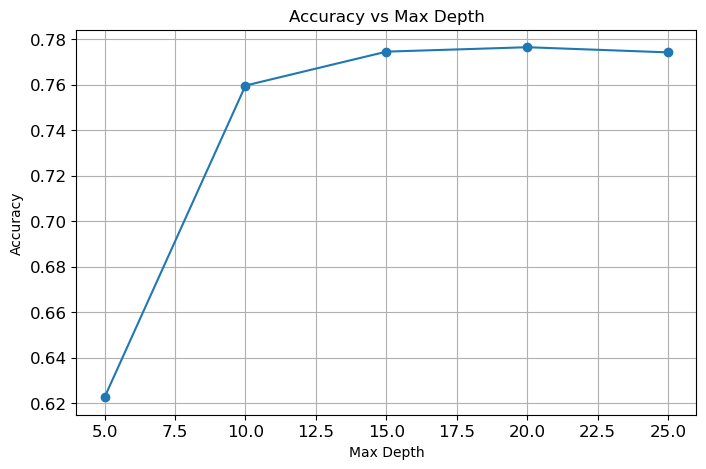

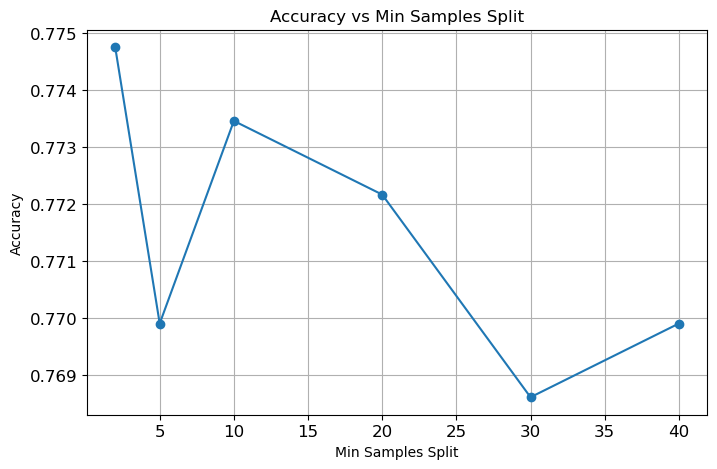

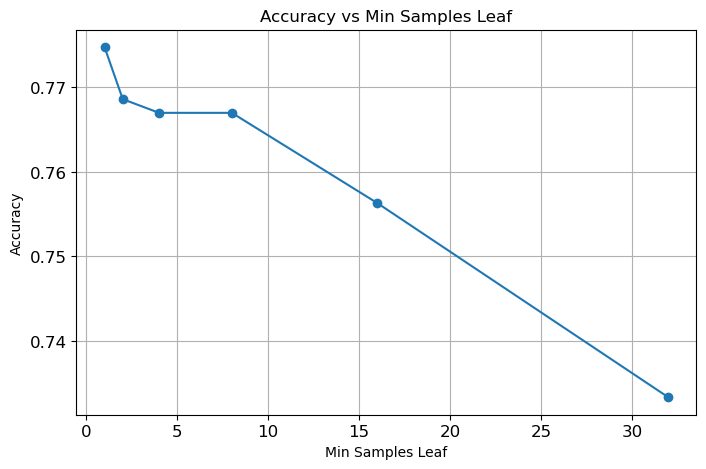

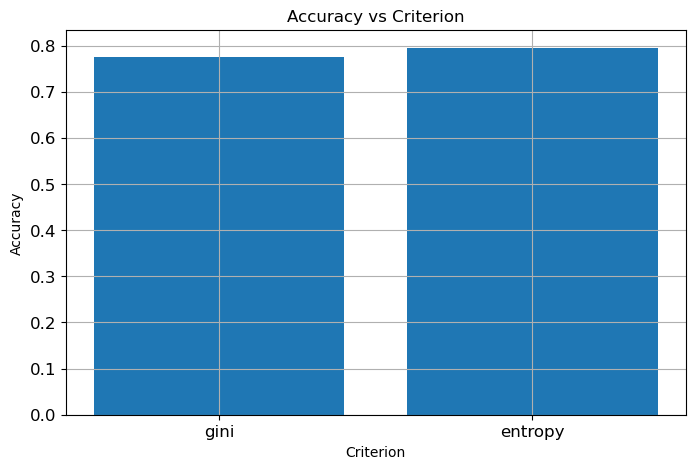

In [ ]:
depth_values = [None, 5, 10, 15, 20, 25]
accuracy_depth = []

for depth in depth_values:
    rf_model = RandomForestClassifier(max_depth=depth, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_depth.append(accuracy)

plt.figure(figsize=(8, 5))
plt.plot(depth_values, accuracy_depth, marker='o')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

split_values = [2, 5, 10, 20, 30, 40]
accuracy_split = []

for split in split_values:
    rf_model = RandomForestClassifier(min_samples_split=split, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_split.append(accuracy)

plt.figure(figsize=(8, 5))
plt.plot(split_values, accuracy_split, marker='o')
plt.title('Accuracy vs Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

leaf_values = [1, 2, 4, 8, 16, 32]
accuracy_leaf = []

for leaf in leaf_values:
    rf_model = RandomForestClassifier(min_samples_leaf=leaf, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_leaf.append(accuracy)

plt.figure(figsize=(8, 5))
plt.plot(leaf_values, accuracy_leaf, marker='o')
plt.title('Accuracy vs Min Samples Leaf')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

criterion_values = ['gini', 'entropy']
accuracy_criterion = []

for criterion in criterion_values:
    rf_model = RandomForestClassifier(criterion=criterion, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_criterion.append(accuracy)

plt.figure(figsize=(8, 5))
plt.bar(criterion_values, accuracy_criterion)
plt.title('Accuracy vs Criterion')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

#### 7.6) Varying Datasets

In [ ]:
def split_dataset(X_train, Y_train, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=split_ratio, random_state=42)

    return x_train, y_train, x_test, y_test

##### 7.6.1) 30% added to test

In [ ]:
x_train_3, y_train_3, x_test_3, y_test_3 = split_dataset(x_train, y_train, 0.3)

y_test = y_test.values.ravel()

new_x_test_30 = np.concatenate([x_test, x_test_3], axis=0)
new_y_test_30 = np.concatenate([y_test, y_test_3], axis=0)

print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 30% Test Set:", x_test_3.shape)
print("Shape of Concatenated Test Set:", new_x_test_30.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 30% Test Set: (2907, 2304)
Shape of Concatenated Test Set: (5997, 2304)


In [ ]:
classifier_rf_30= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_30.fit(x_train_3, y_train_3)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
y_predict_train30 = classifier_rf_30.predict(x_train_3)

accuracy_30 = accuracy_score(y_train_3, y_predict_train30)
report_30 = classification_report(y_train_3, y_predict_train30, zero_division=1)

print(f'Accuracy: {accuracy_30}')
print(f'Classification Report:\n {report_30}')

Accuracy: 0.754828247088309
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.71      0.81      0.76      1555
           2       0.73      0.81      0.77      1572
           3       0.70      0.82      0.76       984
           4       0.85      0.82      0.84      1393
           5       1.00      0.17      0.29       139
           6       0.86      0.60      0.70       260
           7       1.00      0.62      0.76       175
           8       0.74      0.64      0.69       382
           9       0.94      0.52      0.67       188

    accuracy                           0.75      6783
   macro avg       0.85      0.58      0.62      6783
weighted avg       0.77      0.75      0.74      6783



In [ ]:
y_predict_test30 = classifier_rf.predict(new_x_test_30)

accuracy_test30 = accuracy_score(new_y_test_30, y_predict_test30)
report_test30 = classification_report(new_y_test_30, y_predict_test30, zero_division=1)

print(f'Accuracy: {accuracy_test30}')
print(f'Classification Report:\n {report_test30}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.6866766716691679
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.66      0.82      0.73      1385
           2       0.66      0.76      0.71      1428
           3       0.64      0.74      0.69       876
           4       0.80      0.71      0.75      1247
           5       1.00      0.21      0.35       131
           6       0.74      0.27      0.40       190
           7       1.00      0.30      0.46       125
           8       0.59      0.56      0.58       308
           9       0.90      0.41      0.57       172

    accuracy                           0.69      5997
   macro avg       0.80      0.48      0.52      5997
weighted avg       0.71      0.69      0.67      5997



##### 7.6.2) 60% added to test

In [ ]:
x_train_6, y_train_6, x_test_6, y_test_6 = split_dataset(x_train, y_train, 0.6)

new_x_test_60 = np.concatenate([x_test, x_test_6], axis=0)
new_y_test_60 = np.concatenate([y_test, y_test_6], axis=0)

print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 60% Test Set:", x_test_6.shape)
print("Shape of Concatenated Test Set:", new_x_test_60.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 60% Test Set: (5814, 2304)
Shape of Concatenated Test Set: (8904, 2304)


In [ ]:
classifier_rf_60= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_60.fit(x_train_6, y_train_6)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
y_predict_train60 = classifier_rf_60.predict(x_train_6)

accuracy_60 = accuracy_score(y_train_6, y_predict_train60)
report_60 = classification_report(y_train_6, y_predict_train60, zero_division=1)

print(f'Accuracy: {accuracy_60}')
print(f'Classification Report:\n {report_60}')

Accuracy: 0.7739938080495357
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        76
           1       0.71      0.85      0.77       884
           2       0.74      0.83      0.78       892
           3       0.73      0.82      0.77       544
           4       0.88      0.85      0.86       829
           5       1.00      0.17      0.29        81
           6       0.96      0.61      0.74       141
           7       1.00      0.50      0.67        96
           8       0.81      0.69      0.75       222
           9       0.93      0.56      0.70       111

    accuracy                           0.77      3876
   macro avg       0.88      0.59      0.63      3876
weighted avg       0.80      0.77      0.76      3876



In [ ]:
y_predict_test60 = classifier_rf.predict(new_x_test_60)

accuracy_test60 = accuracy_score(new_y_test_60, y_predict_test60)
report_test60 = classification_report(new_y_test_60, y_predict_test60, zero_division=1)

print(f'Accuracy: {accuracy_test60}')
print(f'Classification Report:\n {report_test60}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.7070979335130279
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       194
           1       0.67      0.83      0.74      2056
           2       0.68      0.77      0.72      2108
           3       0.66      0.75      0.70      1316
           4       0.82      0.75      0.78      1811
           5       1.00      0.27      0.42       189
           6       0.80      0.35      0.49       309
           7       1.00      0.44      0.61       204
           8       0.65      0.58      0.61       468
           9       0.90      0.43      0.58       249

    accuracy                           0.71      8904
   macro avg       0.82      0.52      0.57      8904
weighted avg       0.73      0.71      0.69      8904



#### 7.7) Grid Search CV

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 5, 8, 16, 32, 50],
    'n_estimators': [10, 25, 30, 50],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 10,
                           n_jobs=-1,
                           scoring="accuracy")

grid_search.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4, 5, 8, 16, 32, 50],
                         'n_estimators': [10, 25, 30, 50]},
             scoring='accuracy')

In [ ]:
grid_search.best_score_

0.8008255933952528

In [ ]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       n_estimators=50, n_jobs=-1, random_state=42)

#### 7.8) Analyzing train and test datasets with Optimal Random Forest Parameters 

In [ ]:
optimal_rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf.fit(x_train, y_train)
opt_y_train = optimal_rf.predict(x_train)
opt_y_test = optimal_rf.predict(x_test)


optimal_rf_30 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf_30.fit(x_train, y_train)
opt_y_train_3 = optimal_rf_30.predict(x_train_3)
opt_y_test_3 = optimal_rf_30.predict(new_x_test_30)


optimal_rf_60 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf_60.fit(x_train, y_train)
opt_y_train_6 = optimal_rf_60.predict(x_train_6)
opt_y_test_6 = optimal_rf_60.predict(new_x_test_60)

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
optimal_rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf.fit(x_train, y_train)
opt_y_train = optimal_rf.predict(x_train)
opt_y_test = optimal_rf.predict(x_test)


optimal_rf_30 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf_30.fit(x_train, y_train)
opt_y_train_3 = optimal_rf_30.predict(x_train_3)
opt_y_test_3 = optimal_rf_30.predict(new_x_test_30)


optimal_rf_60 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
optimal_rf_60.fit(x_train, y_train)
opt_y_train_6 = optimal_rf_60.predict(x_train_6)
opt_y_test_6 = optimal_rf_60.predict(new_x_test_60)

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
accuracy_train = accuracy_score(y_train, opt_y_train)
accuracy_test = accuracy_score(y_test, opt_y_test)

accuracy_30_train = accuracy_score(y_train_3, opt_y_train_3)
accuracy_30_test= accuracy_score(new_y_test_30, opt_y_test_3)

accuracy_60_train = accuracy_score(y_train_6, opt_y_train_6)
accuracy_60_test = accuracy_score(new_y_test_60, opt_y_test_6)

print(f'Training Accuracy: {accuracy_train}')
print(f'Testing Accuracy: {accuracy_test}')
print(f'Training Accuracy with 30% instances moved to testing: {accuracy_30_train}')
print(f'Testing Accuracy with 30% instances moved to testing: {accuracy_30_test}')
print(f'Training Accuracy with 60% instances moved to testing: {accuracy_60_train}')
print(f'Testing Accuracy with 60% instances moved to testing: {accuracy_60_test}')

Training Accuracy: 0.9998968008255934
Testing Accuracy: 0.7770226537216829
Training Accuracy with 30% instances moved to testing: 1.0
Testing Accuracy with 30% instances moved to testing: 0.8849424712356178
Training Accuracy with 60% instances moved to testing: 1.0
Testing Accuracy with 60% instances moved to testing: 0.9225067385444744


#### 7.9) Analyzing Results from the point of view of the problem of classifier over-fitting

The Random Forest Classifier, trained and tested on the given datasets, show a noticeable gap between the training and testing accuracies at 75.42% and 62.26% respectively. The same metric for the new datasets are as follows:

- **30% Train Instances:**
  - Training Accuracy: 75.48%
  - Testing Accuracy: 68.66%
<br></br>
- **60% Train Instances:**
  - Training Accuracy: 77.39%
  - Testing Accuracy: 70.70%


These two classifiers are comparatively better at generalising than the classifier that uses the original train and test datasets. 

The accuracy scores of training and testing datasets utilising the optimal parameters suggested by grid search show clear signs of overfitting as seen above with their training and testing accuracies. 